In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PATH_SOURCE_DATA'] = '/workspace/projects/boostdm/nature-release/source-data'

In [7]:
import os
import sys
sys.path.append('./scripts/')
import glob
import gzip
import pickle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
from matplotlib import collections as mc
from matplotlib import cm
cmap = cm.RdYlGn_r

import conf
import oncotree
from feature_complexity import linear_complexity, shap_pca_plot

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

# Extended Figure 2a

In [4]:
%%time

prediction_folder = os.path.join(conf.output_boostdm, 'saturation', 'prediction')
df_drivers = pd.read_csv(conf.drivers_path, sep='\t')
role_dict = dict(list(map(tuple, df_drivers[['SYMBOL', 'ROLE']].drop_duplicates().values.tolist())))
df = pd.read_csv(os.path.join(conf.output_boostdm, 'discovery', 'discovery.tsv'), sep='\t')
df['linear_complexity'] = df.apply(lambda r: linear_complexity(r['gene'], r['ttype'], prediction_folder), axis=1)

CPU times: user 1min 17s, sys: 3.02 s, total: 1min 20s
Wall time: 2min 43s


In [5]:
# single variance explained

def variance_explained_plot(gene, ttype):
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    y = shap_pca_plot(gene, ttype, prediction_folder)
    x = range(len(y))
    
    ax.plot(y, '--', label=f'{gene}: {ttype}', lw=3, alpha=1., c=conf.dict_colors_role[role_dict[gene]])
    ax.fill_between(x, 1, y, alpha=0.2, color=conf.dict_colors_role[role_dict[gene]])
    ax.set_ylabel('between y1 and 0')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'SHAP PCA\n{gene}: {ttype}')
    ax.set_xlabel('Number of PCs')
    ax.set_ylabel('Proportion of Variance Explained')
    
    plt.savefig(f'./raw_plots/pca-varexplained.{gene}.{ttype}.svg', dpi=300)
    plt.show()

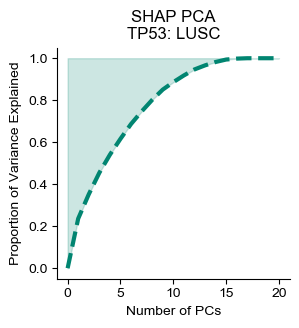

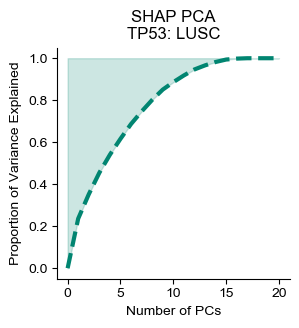

In [8]:
variance_explained_plot('TP53', 'LUSC')

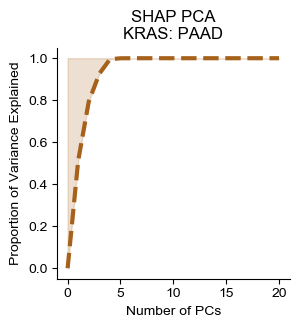

In [9]:
variance_explained_plot('KRAS', 'PAAD')

In [10]:
df_annotated = df[~df['linear_complexity'].isnull()]

In [11]:
# variance explained for several cases at once

def several_variance_explained(*gene_ttype_args):
    
    for i, (gene, ttype) in enumerate(gene_ttype_args):
        
        y = shap_pca_plot(gene, ttype, prediction_folder)
        
        color = conf.dict_colors_role[role_dict[gene]]
        
        i = df_annotated[(df_annotated['gene'] == gene) & (df_annotated['ttype'] == ttype)].index[0]
        complexity = df_annotated.loc[i, 'linear_complexity']
        ax.plot(y[:11], label=f'{gene}: {ttype}: {complexity:.2f}', lw=5, alpha=.5)

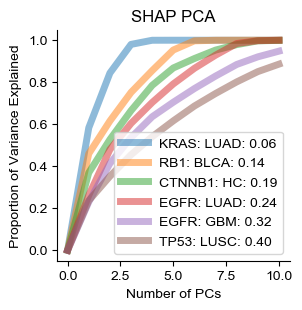

In [12]:
fig, ax = plt.subplots(figsize=(3,3))
l = [('KRAS', 'LUAD'), ('RB1', 'BLCA'), ('CTNNB1', 'HC'), ('EGFR', 'LUAD'),  
     ('EGFR', 'GBM'), ('TP53', 'LUSC')]
several_variance_explained(*l)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f'SHAP PCA')
ax.set_xlabel('Number of PCs')
ax.set_ylabel('Proportion of Variance Explained')
plt.legend()
plt.savefig(f'./raw_plots/shap.pca.several.svg', dpi=300)
plt.show()

# Extended Figure 2b

In [13]:
outputs = [os.path.join(conf.output_boostdm, 'uniform-downsamples', 'output_1')] + \
          [os.path.join(conf.output_boostdm, 'uniform-downsamples', f'output_downsampling_{perc}') for perc in range(95, 10, -5)]
            
prediction_folders = list(map(lambda x: os.path.join(x, 'saturation', 'prediction'), outputs))
evaluation_folders = list(map(lambda x: os.path.join(x, 'evaluation'), outputs))


def get_size_perf(gene, ttype, evaluation_folder, metric='fscore50'):
    
    fn = os.path.join(evaluation_folder, ttype, f'{gene}.eval.pickle.gz')
    with gzip.open(fn, 'rb') as g:
        eval_dict = pickle.load(g)

    return eval_dict[metric], eval_dict['size']


def downsampling_with_complexity(gene, ttype, prediction_folders, evaluation_folders):

    complexities = []
    perf = []
    high = []
    low = []
    size = []

    for i, (pred_folder, eval_folder) in enumerate(zip(prediction_folders, evaluation_folders)):
        complexities.append(linear_complexity(gene, ttype, pred_folder, suffix='80.30.tsv.gz'))
        perfs, sizes = get_size_perf(gene, ttype, eval_folder)
        perf.append(np.nanmedian(perfs))
        high.append(np.nanpercentile(perfs, 75))
        low.append(np.nanpercentile(perfs, 25))
        size.append(i)
        
    # plotting
    
    fig, ax = plt.subplots(figsize=(6,3))
    ax.set_xticks(size)
    ax.set_xticklabels(['full'] + list(map(lambda x: str(x) + '%', range(95, 5, -5))), rotation=90)
    
    p = plt.scatter(size, perf, cmap=cmap, c=complexities, vmin=0., vmax=0.4, s=200, alpha=1, edgecolors='black')
    cbar = fig.colorbar(p)
    cbar.ax.set_ylabel('Feature Complexity', rotation=270, labelpad=15)
    color = p.get_facecolors()[0].tolist()
    
    lows = list(zip(size, low))
    highs = list(zip(size, high))
    lines =  list(zip(lows, highs))
    lc = mc.LineCollection(lines, linewidths=1, alpha=1, colors=color)
    ax.add_collection(lc)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{gene}:{ttype}')
    ax.set_ylabel('F-score')
    ax.set_xlabel('cohort-wise downsampling')
    
    ax.set_ylim(0.6,)
    
    plt.savefig(f'./raw_plots/{gene}.{ttype}.performance.complexity.svg', dpi=300, bbox_inches='tight')
    plt.show()

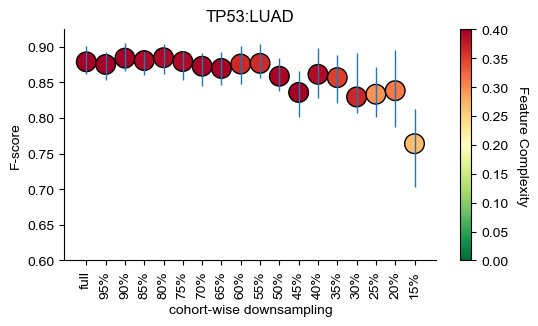

In [14]:
downsampling_with_complexity('TP53', 'LUAD', prediction_folders, evaluation_folders)

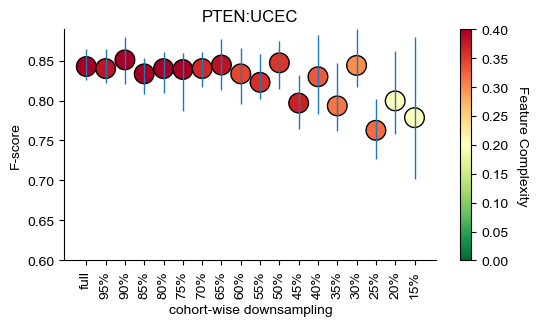

In [15]:
downsampling_with_complexity('PTEN', 'UCEC', prediction_folders, evaluation_folders)

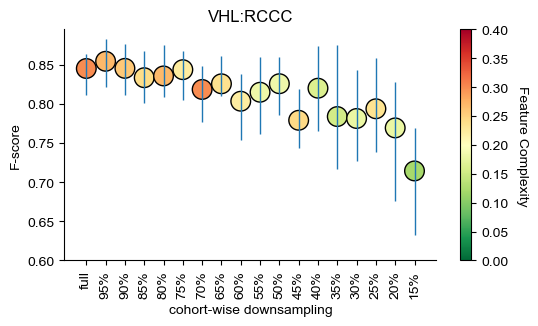

In [16]:
downsampling_with_complexity('VHL', 'RCCC', prediction_folders, evaluation_folders)

# Extended Figure 2c

In [17]:
create_datasets = os.path.join(conf.output_boostdm, 'create_datasets')
output_sampleholdout = os.path.join(conf.output_boostdm, 'sample-holdout/output_10')
prediction_folder = os.path.join(output_sampleholdout, 'saturation', 'prediction')

In [18]:
tree = oncotree.Oncotree()
leaves = tree.get_ttypes('CANCER')

In [19]:
specific = []
for fn in tqdm(glob.glob(os.path.join(prediction_folder, '*.*.prediction.tsv.gz'))):
    gene, _ = tuple(os.path.basename(fn).split('.')[:2])
    df = pd.read_csv(fn, sep='\t')
    ttype = df['selected_model_ttype'].values[0]
    if ttype in leaves:
        specific.append((gene, ttype))

100%|██████████| 227/227 [01:59<00:00,  1.91it/s]


In [20]:
# annotate tumor type

drivers = pd.read_csv(conf.drivers_path, sep='\t')
role_dict = dict(zip(drivers['SYMBOL'].values, drivers['ROLE'].values))

In [21]:
# load held-out mutations

holdout_fn = os.path.join(conf.output_boostdm, 'sample-holdout', 'sampleholdout.10.tsv')
holdout_data = pd.read_csv(holdout_fn, sep='\t')

cohort_ttype_dict = dict(zip(drivers['COHORT'], drivers['CANCER_TYPE']))
holdout_data['ttype'] = holdout_data['COHORT'].apply(lambda x: cohort_ttype_dict.get(x, None))
holdout_data.dropna(axis=0, inplace=True)

# annotate driver/passenger

all_cohorts = []

for cohort in tqdm(holdout_data.COHORT.unique()):
    holdout_cohort = holdout_data[holdout_data['COHORT'] == cohort]
    try:
        df = pd.read_csv(os.path.join(create_datasets, f'{cohort}.regression_data.tsv'), sep='\t')
    except FileNotFoundError:
        print(cohort)
        continue
    df['chr'] = df['chr'].astype(str)
    df['pos'] = df['pos'].astype(int)
    holdout_cohort = holdout_cohort.merge(df[['chr', 'pos', 'ref', 'alt', 'gene', 'response']], on=['chr', 'pos', 'ref', 'alt', 'gene'], how='outer', indicator=True)
    holdout_cohort = holdout_cohort[holdout_cohort['_merge'].isin(['left_only', 'both'])]
    holdout_cohort = holdout_cohort.drop(columns=['_merge'])
    holdout_cohort['response'] = holdout_cohort['response'].fillna(0)
    all_cohorts.append(holdout_cohort)

all_cohorts = pd.concat(all_cohorts, axis=0)

 73%|███████▎  | 151/206 [03:22<00:42,  1.29it/s]

PEDCBIOP_WXS_BLY-PRY


100%|██████████| 206/206 [04:11<00:00,  1.22s/it]


In [22]:
all_cohorts_effective = all_cohorts[all_cohorts.apply(lambda r: (r['gene'], r['ttype']), axis=1).isin(specific)]

In [23]:
merged = []
for gene, ttype in tqdm(specific):
    df = pd.read_csv(os.path.join(prediction_folder, f'{gene}.{ttype}.prediction.tsv.gz'), sep='\t')
    dg = all_cohorts_effective[(all_cohorts_effective['gene'] == gene) & (all_cohorts_effective['ttype'] == ttype)]
    dg = dg.merge(df[['pos', 'alt', 'gene', 'boostDM_score']], on=['pos', 'alt', 'gene'])
    merged.append(dg)
merged = pd.concat(merged, axis=0, sort=True)

100%|██████████| 165/165 [00:25<00:00,  6.42it/s]


In [24]:
def get_fbeta(r, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * r['TP']) / ((p * r['TP']) + (p - 1) * r['FN'] + r['FP'])
    except:
        return None

In [25]:
def get_confusion(df, prediction, response):
    
    p = df[prediction].values >= 0.5
    r = df[response].values
    
    df[f'TP'] = p * r
    df[f'FP'] = p * (1 - r)
    df[f'TN'] = (1 - p) * (1 - r)
    df[f'FN'] = (1 - p) * r
    
    return df

merged = get_confusion(merged, 'boostDM_score', 'response')

In [26]:
df = merged.drop_duplicates().groupby(['gene', 'ttype']).sum()[['TP', 'FP', 'TN', 'FN']].reset_index()
df['fscore50_holdout'] = df.apply(get_fbeta, axis=1)

In [27]:
# get gene-ttype F-score

evaluation = os.path.join(conf.output_boostdm, 'evaluation')

def retrieve_fscore(gene, ttype):
    try:
        with gzip.open(os.path.join(evaluation, ttype, f'{gene}.eval.pickle.gz'), 'rb') as g:
            d = pickle.load(g)
        score = np.nanmedian(d['fscore50'])
        score_up = np.nanpercentile(d['fscore50'], 75)
        score_down = np.nanpercentile(d['fscore50'], 25)
    except FileNotFoundError:
        score, score_up, score_down = None, None, None
    return score, score_up, score_down

df['fscore50_original'], df['fscore50_original_up'], df['fscore50_original_down'] = zip(*df.apply(lambda r: retrieve_fscore(r['gene'], r['ttype']), axis=1))

In [28]:
df.dropna(inplace=True)

In [29]:
def boxplot_sample_holdout(moa, title, outfn):
    
    fig, ax = plt.subplots(figsize=(3,3))
    box = [df[df.apply(lambda x: role_dict[x['gene']], 
                       axis=1).isin([moa])]['fscore50_original'].values, 
           df[df.apply(lambda x: role_dict[x['gene']], 
                       axis=1).isin([moa])]['fscore50_holdout'].values]
    x = [1] * len(box[0]) + [2] * len(box[1])
    x = x + np.random.normal(0, 0.01, size=len(x))
    y = list(box[0]) + list(box[1])
    ax.scatter(x, y, alpha=0.3, s=10)
    ax.boxplot(box, showfliers=False, widths=0.5)
    ax.set_xticklabels(['full model\n(cross-validation)', 'hold-out'])
    ax.set_ylabel('F-score50')
    ax.set_title(f'{title} (n={len(box[0])})')
    ax.set_ylim(0.7, 1.01)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(f'./raw_plots/{outfn}', bbox_inches='tight')
    plt.show()
    return mannwhitneyu(box[0], box[1])

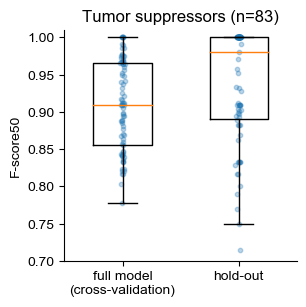

MannwhitneyuResult(statistic=2459.5, pvalue=0.0006540242176421516)

In [30]:
 boxplot_sample_holdout('LoF', 'Tumor suppressors', 'sampleholdout.tumor-suppressors.svg')

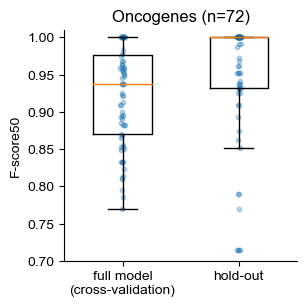

MannwhitneyuResult(statistic=1795.5, pvalue=0.0005508747777012656)

In [31]:
 boxplot_sample_holdout('Act', 'Oncogenes', 'sampleholdout.oncogenes.svg')

In [32]:
# scatter plot

def plot_gene(gene):

    dg = df[(df['gene'] == gene)]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(dg['fscore50_original'], dg['fscore50_holdout'], s=100, alpha=0.5)
    for i, ttype in enumerate(dg['ttype'].values):
        x = dg['fscore50_original'].values[i]
        y = dg['fscore50_holdout'].values[i]
        x_up = dg['fscore50_original_up'].values[i] 
        x_down = dg['fscore50_original_down'].values[i]

        upper = list(zip([x_up], [y]))
        lower = list(zip([x_down], [y]))
        lines = list(zip(lower, upper))
        lc = mc.LineCollection(lines, linewidths=3, alpha=0.5)
        ax.add_collection(lc)

        ax.text(dg['fscore50_original'].values[i] + 0.01, 
                dg['fscore50_holdout'].values[i] + 0.01, f'{ttype}')
    ax.plot([0.75, 1], [0.75, 1], '--')
    ax.set_title(gene)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('cross-validation (F-score50) with IQ range')
    ax.set_ylabel('sample hold-out (F-score50)')
    plt.savefig(f'./raw_plots/{gene}.sampleholdout.10.svg', bbox_inches='tight')
    plt.show()

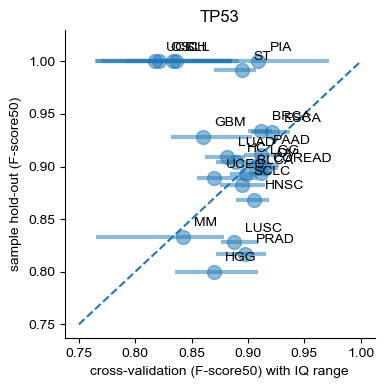

In [33]:
plot_gene('TP53')